<a href="https://colab.research.google.com/github/ianara01/Park-Sangjin/blob/master/Chemistry221111.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 패키지 설치
!pip install git+https://github.com/samoturk/mol2vec;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/samoturk/mol2vec to /tmp/pip-req-build-gm0efn4b
  Running command git clone -q https://github.com/samoturk/mol2vec /tmp/pip-req-build-gm0efn4b
     |████████████████████████████████| 1.6 MB 5.3 MB/s 
  Created wheel for mol2vec: filename=mol2vec-0.1-py3-none-any.whl size=14038 sha256=44271667cceee19570086d1fc656afbbb17775888ba41ec79dad24555b26e429
  Stored in directory: /tmp/pip-ephem-wheel-cache-_ozcrnxb/wheels/80/d5/e1/90dc211e4a17780f99eaec43328470a70284cd731ef2a77034
Successfully built mol2vec


In [7]:
!pip -q install rdkit-pypi
# !pip install deepchem
# !conda install -y -c rdkit rdkit;

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

import seaborn as sns
from rdkit import Chem 
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import IPythonConsole     # 화면에 출력하기 위한 옵션
IPythonConsole.ipython_useSVG=True
%config InlineBackend.figure_format = 'retina' # 레티나 디스플레이 사용
from rdkit.Chem import Draw

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [32]:
# 데이터 다운로드
df= pd.read_csv('https://raw.githubusercontent.com/StillWork/data/master/logP_dataset.csv', names=['smiles', 'logP'])
print(df.shape)
df[:3]

(14610, 2)


,smiles,logP
0,C[C@H]([C@@H](C)Cl)Cl,2.3
1,C(C=CBr)N,0.3
2,CCC(CO)Br,1.3


In [34]:
from rdkit import Chem 
df['mol'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x)) 
print(type(df['mol'][0]))

<class 'rdkit.Chem.rdchem.Mol'>


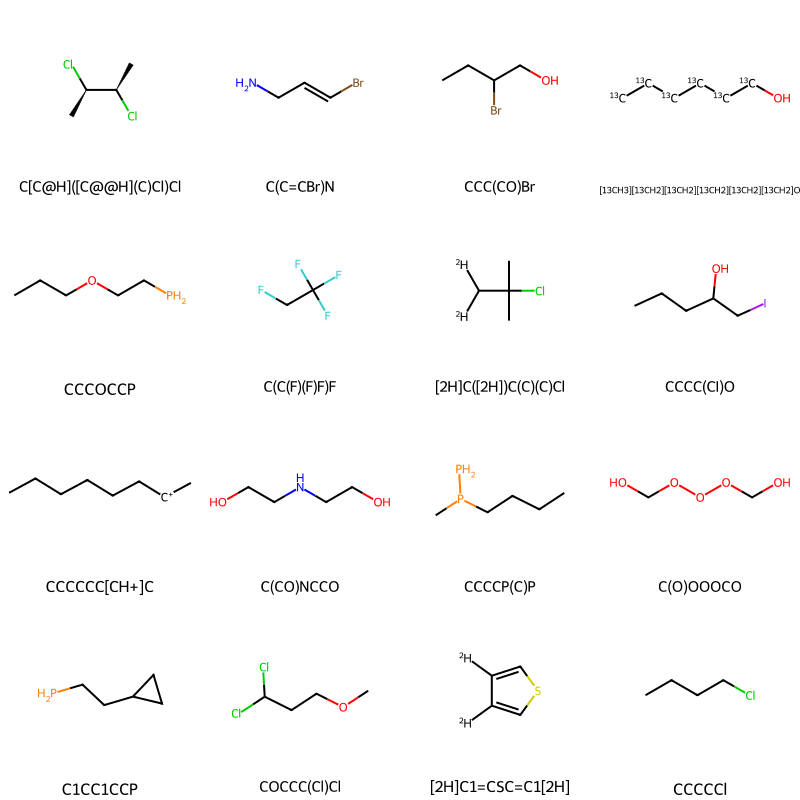

In [35]:
from rdkit.Chem.Draw import IPythonConsole     # 화면에 출력하기 위한 옵션
IPythonConsole.ipython_useSVG=True
%config InlineBackend.figure_format = 'retina' # 레티나 디스플레이 사용
from rdkit.Chem import Draw

# 16개를 한번에 그려보겠다
mols = df['mol'][:16]
Draw.MolsToGridImage(mols, molsPerRow=4, useSVG=True, legends=list(df['smiles'][:16].values))

In [37]:
# AddHs() mol 객체에 수소 원자를 추가로 표시한다
# GetNumAtoms() 모든 원자 수 얻기
# GetNumHeavyAtoms() 분자량이 1 이상인 분자의 원자수 얻기


df['mol'] = df['mol'].apply(lambda x: Chem.AddHs(x))
df['num_of_atoms'] = df['mol'].apply(lambda x: x.GetNumAtoms())
df['num_of_heavy_atoms'] = df['mol'].apply(lambda x: x.GetNumHeavyAtoms())
df[:3]

,smiles,logP,mol,num_of_atoms,num_of_heavy_atoms
0,C[C@H]([C@@H](C)Cl)Cl,2.3,<rdkit.Chem.rdchem.Mol object at 0x7f55c8108580>,14,6
1,C(C=CBr)N,0.3,<rdkit.Chem.rdchem.Mol object at 0x7f55c8108e40>,11,5
2,CCC(CO)Br,1.3,<rdkit.Chem.rdchem.Mol object at 0x7f55c8108490>,15,6


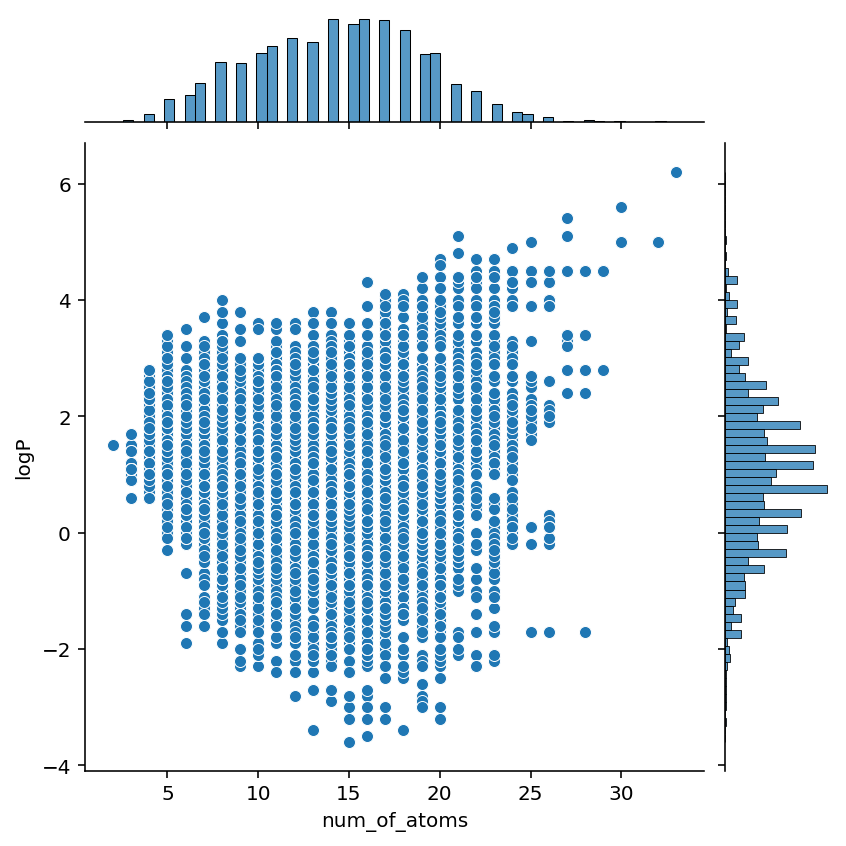

In [38]:
import seaborn as sns
sns.jointplot(df.num_of_atoms, df.logP)
plt.show()

In [39]:
# 탄소 패턴을 지정한다
c_patt = Chem.MolFromSmiles('C')

# 이 패턴이 들어있는 곳을 찾는다. 패턴의 수를 세면 탄소 원자가 몇개 들어있는지 알 수 있다
print(df['mol'][0].GetSubstructMatches(c_patt))

((0,), (1,), (2,), (3,))


In [40]:
# 임의의 패턴(원자)를 포함하는 수를 찾는 함수 정의
def number_of_atoms(atom_list, df):
    for i in atom_list:
        df['num_of_{}_atoms'.format(i)] = df['mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles(i))))

number_of_atoms(['C','O', 'N', 'Cl'], df)

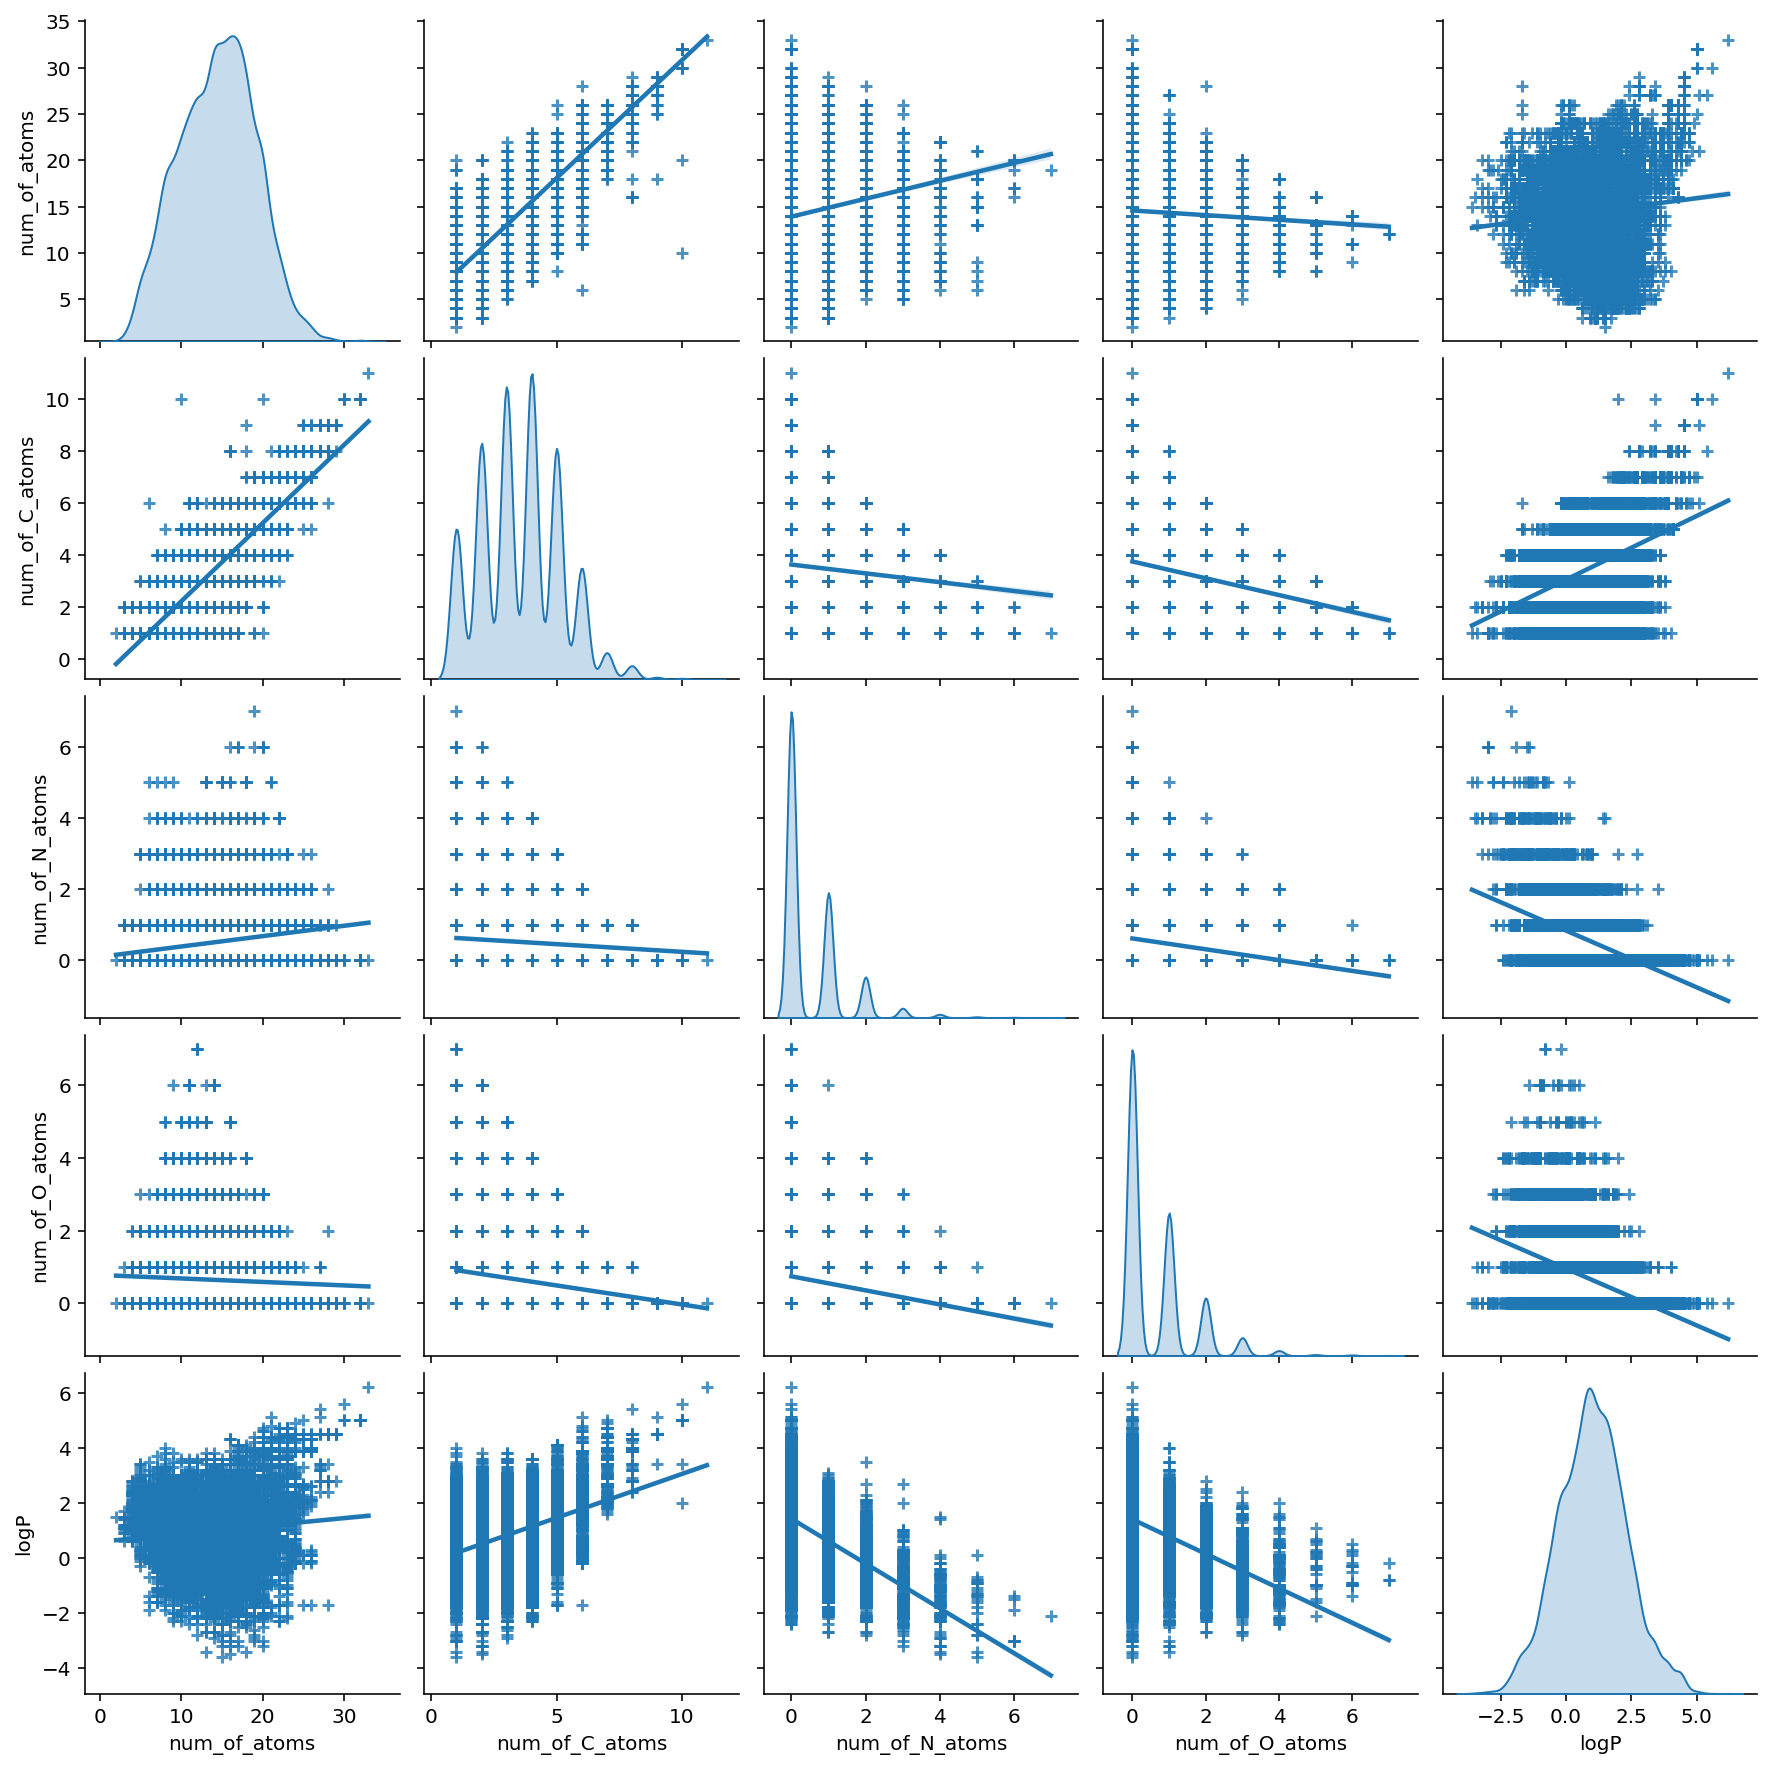

In [41]:
sns.pairplot(df[['num_of_atoms','num_of_C_atoms','num_of_N_atoms', 'num_of_O_atoms', 'logP']], 
             diag_kind='kde', kind='reg', markers='+')
plt.show()

In [42]:
df.shape
df_pre = df.copy()

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# 특성 컬럼을 선택하여 X를 만들고 목적변수를 정의한다
train_df = df.drop(columns=['smiles', 'mol', 'logP'])
y = df['logP'].values

print(train_df.columns)

# 훈련과 검증 데이터를 나눈다

X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=.1, random_state=1)

Index(['num_of_atoms', 'num_of_heavy_atoms', 'num_of_C_atoms',
       'num_of_O_atoms', 'num_of_N_atoms', 'num_of_Cl_atoms'],
      dtype='object')


In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def eval_reg(model, X_test, y_test, N=100):
    prediction = model.predict(X_test)
    mae = mean_absolute_error(y_test, prediction)
    mse = mean_squared_error(y_test, prediction, squared=False)
    R2 = r2_score(y_test, prediction)
    max_err = np.abs(y_test - prediction).max()
    
    print('R2:', round(R2,4))
    print('MAE:', round(mae, 4))
    print('MSE:', round(mse,4))
    print('Max error:', round(max_err, 4))
    if N > 0:
      plt.figure(figsize=(10, 6))
      plt.plot(prediction[:N], ".r-", label="prediction", linewidth=1.0)
      plt.plot(y_test[:N], '.b-', label="actual", linewidth=1.0)
      plt.legend()
      plt.ylabel('logP')
      plt.show()

In [45]:
# AddHs() mol 객체에 수소 원자를 추가로 표시한다
# GetNumAtoms() 모든 원자 수 얻기
# GetNumHeavyAtoms() 분자량이 1 이상인 분자의 원자수 얻기


df['mol'] = df['mol'].apply(lambda x: Chem.AddHs(x))
df['num_of_atoms'] = df['mol'].apply(lambda x: x.GetNumAtoms())
df['num_of_heavy_atoms'] = df['mol'].apply(lambda x: x.GetNumHeavyAtoms())
df[:3]

,smiles,logP,mol,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms
0,C[C@H]([C@@H](C)Cl)Cl,2.3,<rdkit.Chem.rdchem.Mol object at 0x7f55c547a530>,14,6,4,0,0,2
1,C(C=CBr)N,0.3,<rdkit.Chem.rdchem.Mol object at 0x7f55c547a350>,11,5,3,0,1,0
2,CCC(CO)Br,1.3,<rdkit.Chem.rdchem.Mol object at 0x7f55c547a260>,15,6,4,1,0,0


In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# 특성 컬럼을 선택하여 X를 만들고 목적변수를 정의한다
train_df = df.drop(columns=['smiles', 'mol', 'logP'])
y = df['logP'].values

print(train_df.columns)

Index(['num_of_atoms', 'num_of_heavy_atoms', 'num_of_C_atoms',
       'num_of_O_atoms', 'num_of_N_atoms', 'num_of_Cl_atoms'],
      dtype='object')


In [47]:
from rdkit.Chem import Descriptors
df['tpsa'] = df['mol'].apply(lambda x: Descriptors.TPSA(x))
df['mol_w'] = df['mol'].apply(lambda x: Descriptors.ExactMolWt(x))
df['num_valence_electrons'] = df['mol'].apply(lambda x: Descriptors.NumValenceElectrons(x))
df['num_heteroatoms'] = df['mol'].apply(lambda x: Descriptors.NumHeteroatoms(x))

In [48]:
train_df = df.drop(columns=['smiles', 'mol', 'logP'])
y = df['logP'].values

print(train_df.columns)
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=.1, random_state=1)

Index(['num_of_atoms', 'num_of_heavy_atoms', 'num_of_C_atoms',
       'num_of_O_atoms', 'num_of_N_atoms', 'num_of_Cl_atoms', 'tpsa', 'mol_w',
       'num_valence_electrons', 'num_heteroatoms'],
      dtype='object')


In [49]:
# 데이터 다운로드, 목적 변수는 사용하지 않는다 (비지도 학습을 수행하므로)
mdf= pd.read_csv('https://raw.githubusercontent.com/StillWork/data/master/logP_dataset.csv', names=['smiles', 
                                           'target'])
target = mdf['target']
mdf.drop(columns='target',inplace=True)

In [10]:
mdf['mol'] = mdf['smiles'].apply(lambda x: Chem.MolFromSmiles(x))

In [11]:
mdf

,smiles,mol
0,C[C@H]([C@@H](C)Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7f55dbb930d0>
1,C(C=CBr)N,<rdkit.Chem.rdchem.Mol object at 0x7f55dbb93030>
2,CCC(CO)Br,<rdkit.Chem.rdchem.Mol object at 0x7f55dbb93350>
3,[13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O,<rdkit.Chem.rdchem.Mol object at 0x7f55dc0e6f80>
4,CCCOCCP,<rdkit.Chem.rdchem.Mol object at 0x7f55dc0e6f30>
...,...,...
14605,CCC(SC)Br,<rdkit.Chem.rdchem.Mol object at 0x7f55d0e8dd00>
14606,[2H]C([2H])([C@@H](CO)O)O,<rdkit.Chem.rdchem.Mol object at 0x7f55d0e8dd50>
14607,CC(C)NNC,<rdkit.Chem.rdchem.Mol object at 0x7f55d0e8dda0>
14608,C[C@H]1CCC[CH]1,<rdkit.Chem.rdchem.Mol object at 0x7f55d0e8ddf0>


In [12]:
!curl -L -o model_300dim.pkl.zip https://www.dropbox.com/s/fslivdyhkx9lvub/model_300dim.pkl.zip?dl=1

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   127    0   127    0     0    367      0 --:--:-- --:--:-- --:--:--   367
100   342  100   342    0     0    532      0 --:--:-- --:--:-- --:--:--     0
100 54.4M  100 54.4M    0     0  31.5M      0  0:00:01  0:00:01 --:--:--  124M


In [13]:
!unzip -q model_300dim.pkl.zip

In [14]:
# word2vec 모델에 로드한다
from gensim.models import word2vec
model = word2vec.Word2Vec.load('model_300dim.pkl')

In [15]:
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec
print('Molecular sentence:', mol2alt_sentence(mdf['mol'][1], radius=1))
print('\nMolSentence object:', MolSentence(mol2alt_sentence(mdf['mol'][1], radius=1)))
print('\nDfVec object:',DfVec(sentences2vec(MolSentence(mol2alt_sentence(mdf['mol'][1], radius=1)), model, unseen='UNK')))

Molecular sentence: ['2245384272', '772923822', '2246703798', '530246988', '2246703798', '1211882010', '3612926680', '318583445', '847957139', '2592785365']

MolSentence object: MolSentence with 10 words

DfVec object: (10, 300) dimensional vector


In [16]:
# 주어진 14610개의 분자의 표현형을 300차원의 '사전 학습된 embedding vectorization
#Constructing sentences
mdf['sentence'] = mdf.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)

#Extracting embeddings to a numpy.array
#Note that we always should mark unseen='UNK' in sentence2vec() so that model is taught how to handle unknown substructures
mdf['mol2vec'] = [DfVec(x) for x in sentences2vec(mdf['sentence'], model, unseen='UNK')]
X = np.array([x.vec for x in mdf['mol2vec']])
y = target.values

X.shape

(14610, 300)

In [17]:
  X.shape

(14610, 300)

In [18]:
X[:2]

array([[-2.24564999e-01, -1.31193936e+00, -1.32328033e+00,
         3.42851162e-01, -5.50689757e-01,  5.26763618e-01,
         1.37708640e+00, -2.80362457e-01,  3.41727972e+00,
        -9.29850578e-01,  2.31242895e+00,  1.90658307e+00,
         1.74820542e+00, -2.71906942e-01, -9.08046007e-01,
        -1.26393628e+00,  2.48110533e-01, -2.16983724e+00,
         1.32235706e-01,  3.66444302e+00,  1.23099253e-01,
         3.21262717e+00,  2.71492100e+00,  1.20218694e+00,
        -6.25475049e-02,  9.31017101e-01, -5.42483151e-01,
        -4.54702806e+00, -5.75757265e-01, -2.46472549e+00,
         3.15386683e-01,  2.26301014e-01, -1.50404668e+00,
        -2.63647580e+00, -3.81965727e-01, -1.59004223e+00,
        -2.36226141e-01, -1.36436594e+00,  8.66032243e-01,
        -1.95713282e-01, -1.21863961e+00,  1.12967396e+00,
        -1.14992857e+00, -2.12707424e+00,  2.40190953e-01,
         2.82290864e+00, -1.46324587e+00,  3.27431393e+00,
        -3.13970995e+00,  1.02630389e+00, -1.39739347e+0

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

R2: 0.8931
MAE: 0.299
MSE: 0.424
Max error: 2.7076


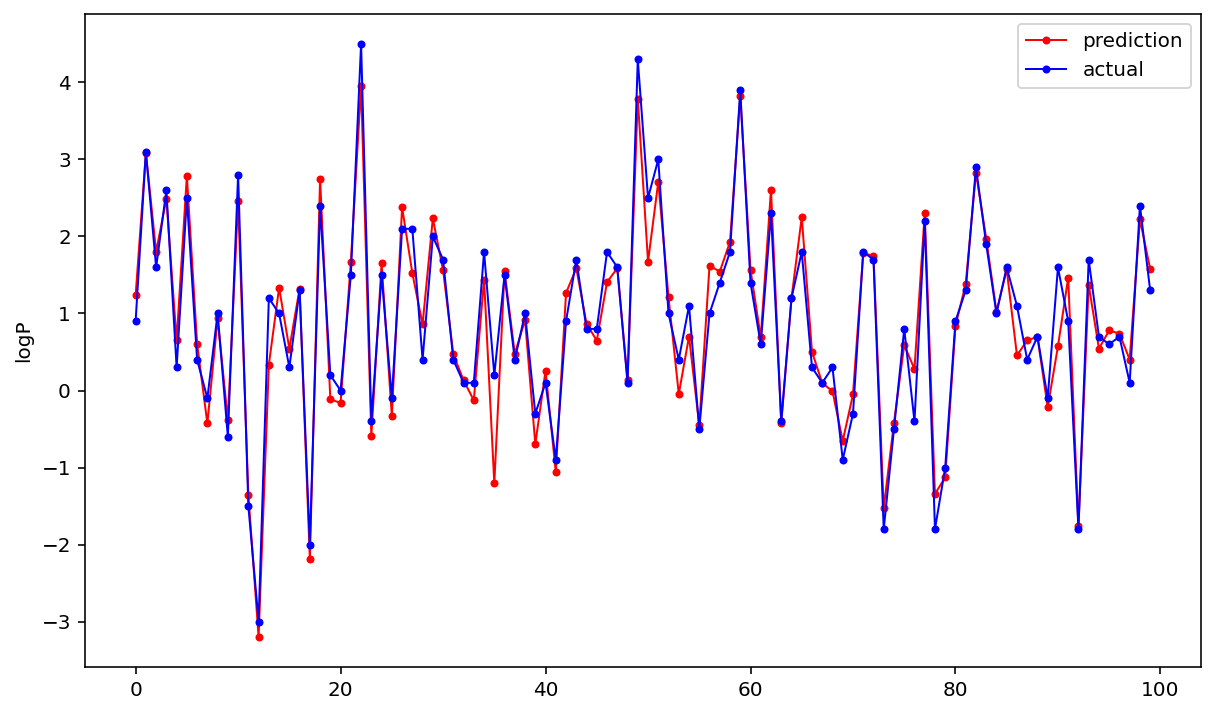

In [28]:
lin = LinearRegression()
lin.fit(X_train, y_train)
eval_reg(lin, X_test, y_test)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=1)
lin.fit(X_train, y_train)
eval_reg(lin, X_test, y_test, 0)

R2: 0.8931
MAE: 0.299
MSE: 0.424
Max error: 2.7076


In [50]:
mdf = pd.DataFrame(X)
new_df = pd.concat((mdf, train_df), axis=1)
new_df.shape

(14610, 310)

R2: 0.9201
MAE: 0.2609
MSE: 0.3667
Max error: 1.847


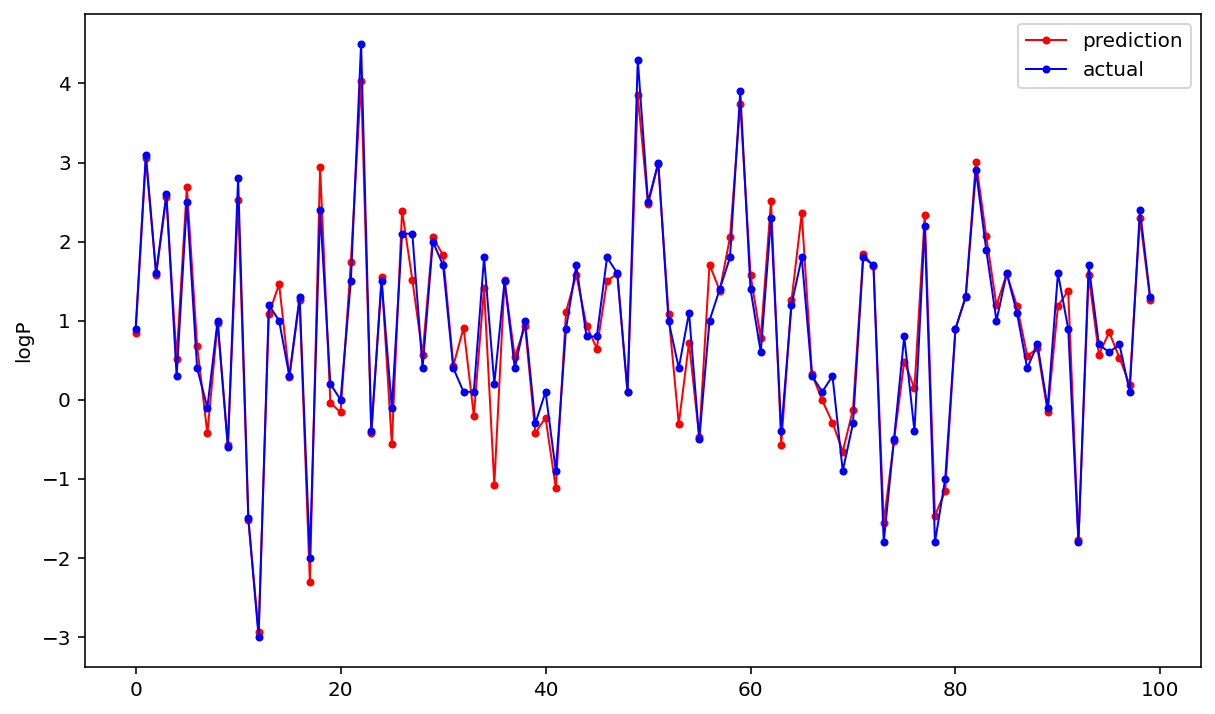

In [51]:
X_train, X_test, y_train, y_test = train_test_split(new_df, y, test_size=.1, random_state=1)
lin.fit(X_train, y_train)
eval_reg(lin, X_test, y_test)

In [52]:
import warnings
warnings.filterwarnings("ignore")
# 데이터 읽기
hiv = pd.read_csv('https://raw.githubusercontent.com/StillWork/data/master/HIV.csv')
print(hiv.shape)
hiv.head()

(41127, 3)


,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0


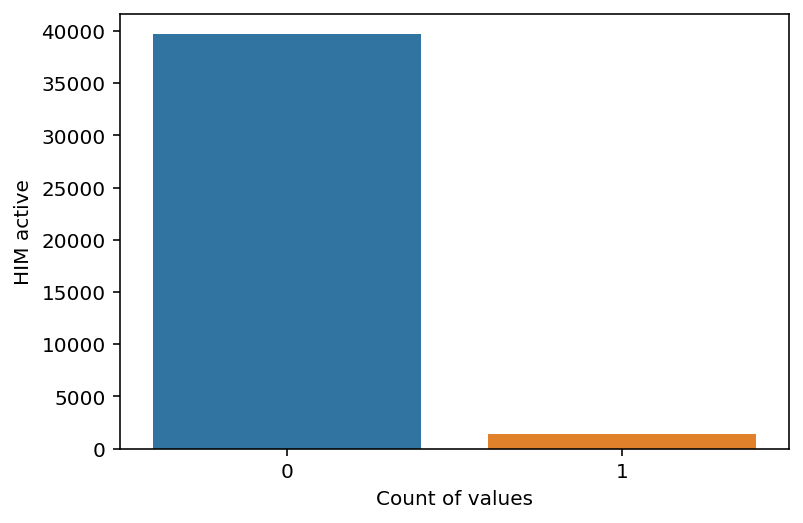

In [53]:
#Let's look at the target values count
sns.countplot(data = hiv, x='HIV_active')
plt.ylabel('HIM active')
plt.xlabel('Count of values')
plt.show()

In [54]:
# SMILES로부터 MOL를 얻는다
hiv['mol'] = hiv['smiles'].apply(lambda x: Chem.MolFromSmiles(x)) 

# 특성을 추가한다
hiv['tpsa'] = hiv['mol'].apply(lambda x: Descriptors.TPSA(x))
hiv['mol_w'] = hiv['mol'].apply(lambda x: Descriptors.ExactMolWt(x))
hiv['num_valence_electrons'] = hiv['mol'].apply(lambda x: Descriptors.NumValenceElectrons(x))
hiv['num_heteroatoms'] = hiv['mol'].apply(lambda x: Descriptors.NumHeteroatoms(x))

In [55]:
y = hiv.HIV_active.values
X = hiv.drop(columns=['smiles', 'activity','HIV_active', 'mol'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=1)

In [56]:
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix, classification_report

def eval_class(model, X_test, y_test):
    y_pred = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)[:,1]

    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))


    fpr, tpr, threshold = roc_curve(y_test, pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, 'g', label = 'AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    print('ROC AUC score:', round(roc_auc, 4))

[[7911    8]
 [ 304    3]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      7919
           1       0.27      0.01      0.02       307

    accuracy                           0.96      8226
   macro avg       0.62      0.50      0.50      8226
weighted avg       0.94      0.96      0.94      8226



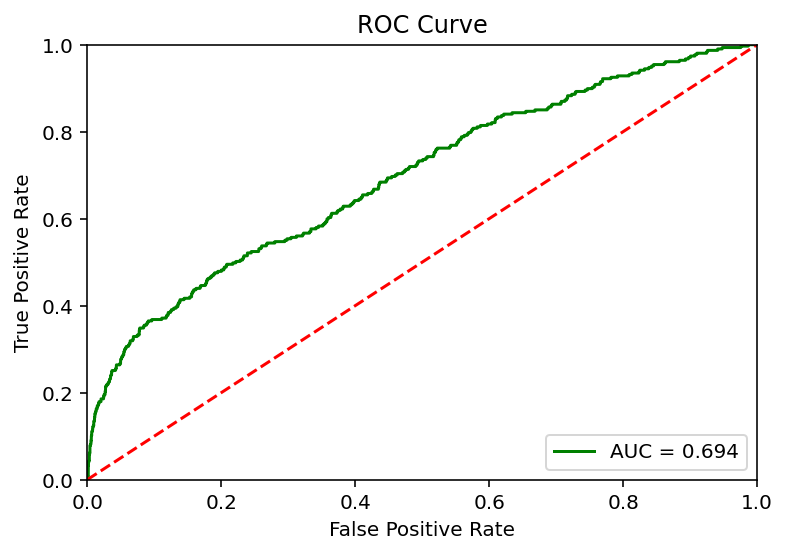

ROC AUC score: 0.6944


In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train, y_train)

eval_class(lr, X_test, y_test)

In [58]:
#Constructing sentences
hiv['sentence'] = hiv.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)

#Extracting embeddings to a numpy.array
#Note that we always should mark unseen='UNK' in sentence2vec() so that model is taught how to handle unknown substructures
hiv['mol2vec'] = [DfVec(x) for x in sentences2vec(hiv['sentence'], model, unseen='UNK')]
X_mol = np.array([x.vec for x in hiv['mol2vec']])
X_mol = pd.DataFrame(X_mol)

#Concatenating matrices of features
new_hiv = pd.concat((X, X_mol), axis=1)

X_train, X_test, y_train, y_test = train_test_split(new_hiv, y, test_size=.20, random_state=1)

In [59]:
new_hiv

,tpsa,mol_w,num_valence_electrons,num_heteroatoms,0,1,2,3,4,5,...,290,291,292,293,294,295,296,297,298,299
0,45.20,319.096508,114,5,1.830049,5.304307,-2.638319,3.339625,2.323060,1.235785,...,-0.768906,1.448456,5.399398,-2.879818,-4.561316,1.645012,-5.821576,-5.047639,-6.124604,-2.643609
1,45.20,563.127808,198,5,1.833409,1.726148,-7.006849,14.767018,-1.094783,-1.150211,...,-7.340128,11.670763,16.230873,-1.561301,-10.885477,-3.017296,-10.604566,-5.053291,-12.438490,1.889469
2,20.31,291.071785,102,3,0.239901,-3.120830,-3.069606,6.872059,-0.438361,-2.307343,...,-0.937189,9.778188,9.964662,-0.317403,-6.865175,-1.519423,-3.289854,-3.003499,-8.488753,-0.337102
3,160.78,370.029328,128,10,2.331327,-0.651370,-6.820276,4.460179,2.888736,2.596256,...,-1.775050,9.360443,10.512185,-0.767903,-10.444510,-4.038017,-8.307643,-1.430080,-11.372781,-2.125236
4,108.74,189.960580,62,8,1.245269,-2.941263,-0.752463,-0.470454,1.706033,1.063615,...,-0.251756,3.133073,2.865110,-0.975226,-4.454810,-2.266666,-4.889390,-2.214254,-4.428329,-1.573864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41122,56.41,379.225977,148,5,2.608390,-6.096492,-1.043300,4.551602,-1.026818,-4.465841,...,0.438865,15.370647,5.072217,-0.921839,-9.943422,-7.371923,-9.762303,-3.053199,-16.724777,-0.977346
41123,71.63,484.236208,186,6,2.587630,-7.165244,-3.397100,5.840809,-1.007105,-6.378576,...,-1.521045,18.698437,5.922796,-1.471869,-11.996766,-11.680764,-13.017939,-4.447889,-18.300247,1.007470
41124,53.17,440.246378,170,4,2.172952,-6.267159,-2.897906,6.958421,-0.721393,-7.033988,...,-0.922732,17.003086,7.426308,-0.394204,-9.616590,-9.777713,-9.794829,-3.518642,-18.048529,0.308658
41125,53.17,440.246378,170,4,2.144235,-6.164550,-2.714616,7.038599,-0.714388,-6.902690,...,-0.778036,16.985701,7.418930,-0.644695,-9.437729,-9.763931,-9.884131,-3.574929,-18.105923,0.157529


[[7892   27]
 [ 244   63]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      7919
           1       0.70      0.21      0.32       307

    accuracy                           0.97      8226
   macro avg       0.84      0.60      0.65      8226
weighted avg       0.96      0.97      0.96      8226



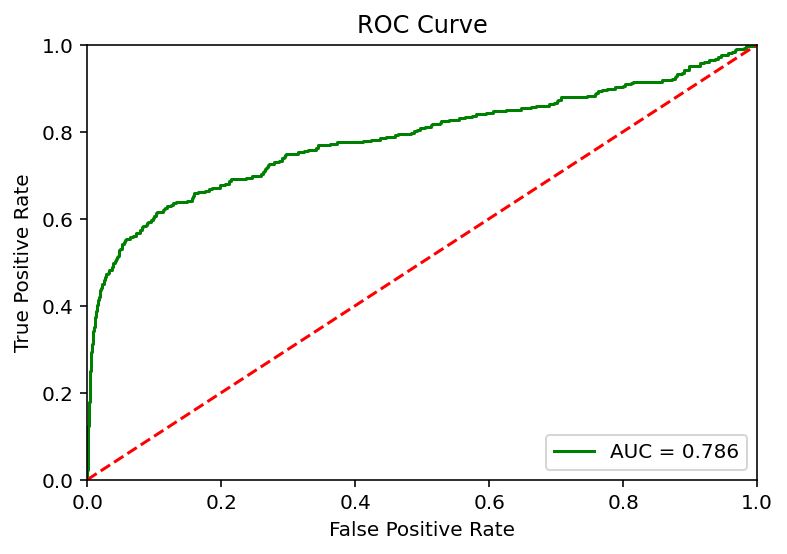

ROC AUC score: 0.7859


In [60]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train, y_train)

eval_class(lr, X_test, y_test)